In [2]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
import shutil
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.plotting.tools import set_rc_params_article
from numcosmo_py.helper import npa_to_seq
#set_rc_params_article(ncol=1,use_tex = bool(shutil.which("latex")))
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery



%matplotlib inline

In [3]:
image_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')
dc2_cosmology = image_cat.cosmology
sky_area = image_cat.sky_area
pz_min = 0.0
pz_max = 1.0
logRmin = 0
logRmax = 3 
data_redmapper = image_cat.get_quantities(
    ["cluster_id", "redshift", "redshift_err", "richness", "richness_err", "ra", "dec"],
    filters=[
        f"redshift > {pz_min}",
        f"redshift < {pz_max}",
        f"richness > {10**logRmin}",
        f"richness < {10**logRmax}",
    ],
)
data_redmapper = Table(data_redmapper)
data_redmapper['richness'] = np.log(data_redmapper['richness'])

cut = np.log(20)

data_redmapper = data_redmapper[data_redmapper['richness'] > cut]
lnRmax = np.log(200)
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("Omegax", dc2_cosmology.Ode0)
cosmo.param_set_by_name("H0", dc2_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", dc2_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", dc2_cosmology.Odm0)  # 0.2603
print(dc2_cosmology.Odm0)
cosmo.param_set_by_name("w", -1.0)  # -1.0
prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA =  0.963

reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)
#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (dc2_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(dc2_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)
dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)





cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.21999999999999997
0.7764593327536546
0.8 0.8 3.0597349179015914


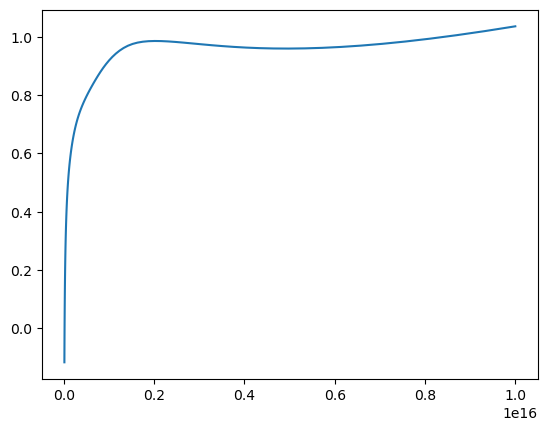

In [29]:
lnM_bins_knots = np.linspace(13.0 * np.log(10), 16 * np.log(10) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnM_centers = 0.5 * (lnM_bins_knots[:-1] + lnM_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

completeness_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))

completeness_smooth_clipped = np.array([[0.03883302, 0.0556372,  0.06203133, 0.06041939, 0.05320534, 0.04279318,
  0.03158687, 0.0185471,  0.01724289],
 [0.23745306, 0.26637725, 0.27993941, 0.28153087, 0.27454294, 0.26236697,
  0.24839427, 0.23148489, 0.2296091 ],
 [0.40082567, 0.43698053, 0.45589722, 0.4615487,  0.45790797, 0.44894802,
  0.43864183, 0.42934926, 0.43937571],
 [0.54218907, 0.58072969, 0.60228042, 0.61110568, 0.61146987, 0.60763743,
  0.60387276, 0.60768125, 0.63562958],
 [0.6747815,  0.71090737, 0.7314647,  0.74083457, 0.74339807, 0.74353626,
  0.74563023, 0.76202187, 0.8074576 ],
 [0.81184117, 0.84079621, 0.85582574, 0.86136818, 0.86186199, 0.86174559,
  0.86545742, 0.88791217, 0.94394664],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751, 0.98089315, 1.0        ],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751, 0.98089315, 1.0        ],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751,  0.98089315, 1.0        ]])

completeness_smooth_clipped = np.array([[1, 1, 1, 1, 1, 1,
 1 , 1 , 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1]])

#cross completeness
completeness_smooth_clipped = np.array([[0.00775574, 0.0257542, 0.03300902, 0.03199418, 0.02518367, 0.01505147, 0.00407155, 0.0, 0.0],
    [0.25260502, 0.27061681, 0.27605795, 0.2718841, 0.26105089, 0.24651397, 0.23122899, 0.21336439, 0.21044216],
    [0.40262404, 0.43122535, 0.4456371, 0.44914992, 0.44505445, 0.43664132, 0.42720117, 0.41831353, 0.42562491],
    [0.50266196, 0.54495916, 0.57169553, 0.58647906, 0.59291775, 0.59461957, 0.59519252, 0.60182781, 0.62621808],
    [0.59756795, 0.64919758, 0.68418232, 0.70655894, 0.72036417, 0.72963479, 0.73840753, 0.75946354, 0.80210609],
    [0.73219118, 0.78131995, 0.81304655, 0.83207695, 0.84311712, 0.85087303, 0.86005064, 0.88677706, 0.94317338],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0]])
 

for i in range(len(z_centers)):
    for j in range(len(lnM_centers)):
        completeness_knots.set(i,j, completeness_smooth_clipped.T[i][j])

completeness = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=completeness_knots
)
completeness.prepare()
lnM_test = np.linspace(13.0 * np.log(10), 16 * np.log(10) ,100)
complete = [completeness.eval(lnM_test[i], 0.6) for i in range(len(lnM_test))]
plt.plot(np.exp(lnM_test),complete)

(5.0, 200.0)

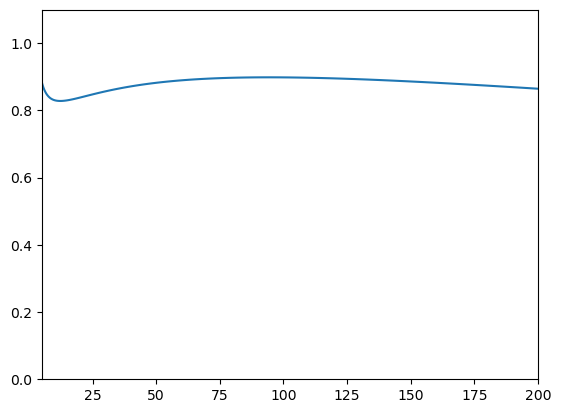

In [25]:
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200])) #5, 10, 15, 
z_bins_knots = np.array([0.1, 0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1]) #0.1, 1.1

lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

purity_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))

purity_smooth_clipped = np.array([[1.434218, 1.328137, 1.262514, 1.222554, 1.199138, 1.185805, 1.177293, 1.163172, 1.134589],
    [1.388353, 1.347753, 1.311515, 1.278701, 1.248615, 1.220633, 1.194240, 1.156687, 1.120475],
    [1.347075, 1.315762, 1.286876, 1.260027, 1.234854, 1.211052, 1.188353, 1.155862, 1.124700],
    [1.301904, 1.257280, 1.226449, 1.205230, 1.190761, 1.180123, 1.171063, 1.155676, 1.132263],
    [1.275060, 1.180890, 1.133459, 1.115116, 1.115412, 1.126516, 1.141000, 1.151368, 1.123676],
    [1.320096, 1.162020, 1.092046, 1.070110, 1.077089, 1.100010, 1.126121, 1.138456, 1.075511],
    [1.482836, 1.219835, 1.114275, 1.081139, 1.087096, 1.111355, 1.133504, 1.112346, 1.000000]])

'''
purity_smooth_clipped = np.array([[1, 1, 1, 1, 1, 1,
 1 , 1 , 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1]])
'''


for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        purity_knots.set(i,j, purity_smooth_clipped.T[i][j])

purity = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=purity_knots
)
purity.prepare()

lnR_test = np.linspace(np.log(5), np.log(200) ,100)
pure = [1/purity.eval(lnR_test[i], .7) for i in range(len(lnR_test))]
plt.plot(np.exp(lnR_test),pure)
plt.ylim(0.0,1.1)
plt.xlim(5,200)

In [6]:
cluster_z = Nc.ClusterRedshiftNodist(z_min = 0.1,z_max = 1.1)
cluster_z = Nc.ClusterPhotozGaussGlobal(pz_min = z_bins_knots[0],pz_max = z_bins_knots[-1])
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
z_bin = [(z_bins_knots[i] +z_bins_knots[i+1])/2 for i in range(len(z_bins_knots)-1)]

sigma_SN        = np.array([])
sigma_intrinsic = np.array([])
for i in range(len(z_bins_knots)-1):
    data_bin = data_redmapper[(data_redmapper['redshift'] >= z_bins_knots[i]) & (data_redmapper['redshift']< z_bins_knots[i+1])]
    sigma_SN = np.append(sigma_SN, np.sum([(data_bin['redshift'][j] - z_bin[i])**2 for j in range(len(data_bin['redshift']))]))
    sigma_intrinsic = np.append(sigma_intrinsic, 1/(np.sum([1/data_bin['redshift_err'][j]**2 for j in range(len(data_bin['redshift_err'])) ])) )
    
sigma2_SN = sigma_SN/len(data_bin['redshift'])**2
sigma2_intrinsic = sigma_intrinsic**2
sigma = np.sqrt(sigma2_SN + sigma2_intrinsic) 

photoz_err = Ncm.Matrix.new(len(sigma), 2)
photoz_err.set_zero()
photoz_err.set_col(1, Ncm.Vector.new_array(npa_to_seq(sigma)))

photoz_err.log_vals("photoz_err:" , "%.10f")
print(sigma2_intrinsic)
print(sigma2_SN)


cluster_m = Nc.ClusterMassAscaso(lnRichness_min=cut, lnRichness_max=lnRmax)
cluster_m.param_set_by_name("cut",cut)
cluster_m.param_set_by_name("mup0", 4.10553311738824)
cluster_m.param_set_by_name("mup1", 1.20608123944386)
cluster_m.param_set_by_name("mup2", 0.486390503888162)
cluster_m.param_set_by_name("sigmap0", 0.381410719134821)
cluster_m.param_set_by_name("sigmap1", -0.16298007644402 )
cluster_m.param_set_by_name("sigmap2", -0.0932793509466485)
#cluster_m.set_purity(purity)
print(cluster_m.intp(cosmo, np.log(10**(14.0)),1.0))

                              

'''
cluster_m.set_property("mup0_fit", True)
cluster_m.set_property("mup1_fit", True)
cluster_m.set_property("mup2_fit", True)
cluster_m.set_property("sigmap0_fit", True)
cluster_m.set_property("sigmap1_fit", True)
cluster_m.set_property("sigmap2_fit", True)
'''

cluster_m_no_cut = Nc.ClusterMassAscaso(lnRichness_min=cut, lnRichness_max=lnRmax)
cluster_m_no_cut.param_set_by_name("cut",-1e20)
cluster_m_no_cut.param_set_by_name("mup0", 4.12769558168741)
cluster_m_no_cut.param_set_by_name("mup1", 1.17476066603899)
cluster_m_no_cut.param_set_by_name("mup2", 0.393577193825473 )
cluster_m_no_cut.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m_no_cut.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m_no_cut.param_set_by_name("sigmap2", -0.0644996574273048 )
'''
cluster_m_no_cut.set_property("mup0_fit", True)
cluster_m_no_cut.set_property("mup1_fit", True)
cluster_m_no_cut.set_property("mup2_fit", True)
cluster_m_no_cut.set_property("sigmap0_fit", True)
cluster_m_no_cut.set_property("sigmap1_fit", True)
cluster_m_no_cut.set_property("sigmap2_fit", True)
'''

photoz_err: [9.55868038e-14 1.32343460e-14 7.62062910e-15 9.70777279e-16
 1.32407841e-15 1.17203853e-14 6.75625882e-15 6.81170650e-15
            inf]
[inf inf inf inf inf inf inf inf nan]
0.19137242731476645
0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 inf
photoz_err: 0.0000000000 -nan


/tmp/ipykernel_395901/1079454871.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_intrinsic = np.append(sigma_intrinsic, 1/(np.sum([1/data_bin['redshift_err'][j]**2 for j in range(len(data_bin['redshift_err'])) ])) )
/tmp/ipykernel_395901/1079454871.py:13: RuntimeWarning: divide by zero encountered in divide
  sigma2_SN = sigma_SN/len(data_bin['redshift'])**2
/tmp/ipykernel_395901/1079454871.py:13: RuntimeWarning: invalid value encountered in divide
  sigma2_SN = sigma_SN/len(data_bin['redshift'])**2


'\ncluster_m_no_cut.set_property("mup0_fit", True)\ncluster_m_no_cut.set_property("mup1_fit", True)\ncluster_m_no_cut.set_property("mup2_fit", True)\ncluster_m_no_cut.set_property("sigmap0_fit", True)\ncluster_m_no_cut.set_property("sigmap1_fit", True)\ncluster_m_no_cut.set_property("sigmap2_fit", True)\n'

6.610816798580809
37690.87199155087
3735
115898.09871193544
4433.764573031197


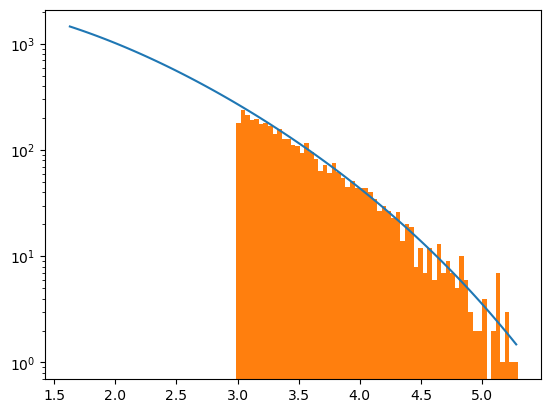

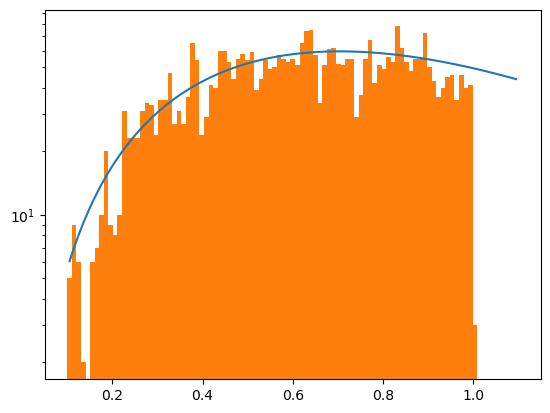

445226.30986320204
38700.507067182625
233119.52729228773


In [7]:
mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)

hbias = Nc.HaloBiasTinker.new(hmf)

cad = Nc.ClusterAbundance.new(hmf,hbias)
cad.set_area(sky_area * (np.pi / 180) ** 2)
cad.prepare(cosmo , cluster_z , cluster_m_no_cut)
print(cad.intp_d2n(cosmo ,cluster_z , cluster_m, np.log(10**(12.0)),0.5))
print(cad.intp_bin_d2n(cosmo ,cluster_z , cluster_m,[np.log(5)], [np.log(200)],None, [0.1],[1.1],None))
print(len(data_redmapper['richness']))
print(cad.intp_bin_d2n_bias(cosmo ,cluster_z , cluster_m,[np.log(5)], [np.log(200)],None, [0.1],[1.1],None))
print(cad.n(cosmo ,cluster_z , cluster_m))

lnR_knots_test = np.linspace(np.log(5), np.log(200), 100)
lnR_bins_test = [(lnR_knots_test[i] + lnR_knots_test[i+1])/2 for i in range(len(lnR_knots_test)-1)]
abundance_lnR = [cad.intp_bin_d2n(cosmo ,cluster_z , cluster_m,[lnR_knots_test[i]], [lnR_knots_test[i+1]],None, [pz_min],[pz_max],None)for i in range(len(lnR_knots_test)-1)]
plt.plot(lnR_bins_test,abundance_lnR)
plt.hist(data_redmapper['richness'] ,bins=lnR_knots_test)
plt.yscale('log')
plt.show()

z_knots_test = np.linspace(0.1, 1.1, 100)
z_bins_test = [(z_knots_test[i] + z_knots_test[i+1])/2 for i in range(len(z_knots_test)-1)]
abundance_z = [cad.intp_bin_d2n(cosmo ,cluster_z , cluster_m, [cut],[np.log(200)],None , [z_knots_test[i]], [z_knots_test[i+1]],None) for i in range(len(z_knots_test)-1)]
plt.plot(z_bins_test,abundance_z)
plt.hist(data_redmapper['redshift'] ,bins=z_knots_test)
plt.yscale('log')
plt.show()

cad_no_cut = Nc.ClusterAbundance.new(hmf,None)
cad_no_cut.set_area(sky_area * (np.pi / 180) ** 2)
cad_no_cut.prepare(cosmo , cluster_z , cluster_m_no_cut)


print(cad_no_cut.intp_d2n(cosmo ,cluster_z , cluster_m_no_cut, np.log(10**(13.0)),1.0))
print(cad_no_cut.intp_bin_d2n(cosmo ,cluster_z , cluster_m_no_cut,[np.log(5)], [np.log(200)],None, [0.1],[1.1],None))
print(cad_no_cut.n(cosmo ,cluster_z , cluster_m_no_cut))

In [8]:
lnR_bins_knots = np.log(np.array([20, 35, 70, 100, 200])) #5, 10, 15, 
z_bins_knots = np.array([0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]) #0.1, 1.1

kernel_z = np.linspace(0.0, 1.9, num=400 + 1)[1:]
kernels_T = np.zeros((len(z_bins_knots)-1, 400))
for i, (zminbin, zmaxbin) in enumerate(zip(z_bins_knots[:-1], z_bins_knots[1:])):
        Dz = zmaxbin - zminbin

        kernel = np.zeros_like(kernel_z)
        kernel[(kernel_z >= zminbin) & (kernel_z <= zmaxbin)] = 1.0
        kernels_T[i] = kernel / Dz
    
S_fullsky_array = PySSC.Sij(kernel_z, kernels_T, cosmo)
S_fullsky = Ncm.Matrix.new_array(S_fullsky_array.flatten(), S_fullsky_array.shape[1])

In [ ]:
bin_counts = []
bin_counts_pure_complete = []
z_bins = [(z_bins_knots[j] + z_bins_knots[j+1])/2 for j in range(len(z_bins_knots)-1)]
lnR_bins = [(lnR_bins_knots[j] + lnR_bins_knots[j+1])/2 for j in range(len(lnR_bins_knots)-1)]
for i in range(len(z_bins_knots)-1):
    bins_coutns_z_i = data_redmapper[(data_redmapper['redshift'] >= z_bins_knots[i]) * (data_redmapper['redshift'] < z_bins_knots[i+1])]

    for j in range(len(lnR_bins_knots)-1):
        bin_counts.append( len(bins_coutns_z_i[(bins_coutns_z_i['richness'] >= lnR_bins_knots[j]) * (bins_coutns_z_i['richness'] < lnR_bins_knots[j+1]
                                                                                                  )]))

z_bins_vec = Ncm.Vector.new_array(npa_to_seq(z_bins_knots))
lnR_bins_vec = Ncm.Vector.new_array(npa_to_seq(lnR_bins_knots))

nc_data_binned = Nc.DataClusterNCountsGauss.new(cad)
nc_data_binned.set_size((z_bins_vec.len() - 1) * (lnR_bins_vec.len() - 1))
nc_data_binned.set_init(True)
nc_data_binned.use_norma(True)
nc_data_binned.set_z_obs(z_bins_vec)
nc_data_binned.set_z_obs_params(photoz_err)
nc_data_binned.set_lnM_obs(lnR_bins_vec)
nc_data_binned.set_has_ssc(True)
nc_data_binned.set_s_matrix(S_fullsky)
nc_data_binned.set_fix_cov(False)

nc_data_binned.peek_mean().set_array(npa_to_seq(bin_counts))
nc_data_binned.peek_mean().log_vals("mean: " , "%.10f", True)
#nc_data_binned.peek_cov().log_vals("cov" , "%.10f")
#S_fullsky.log_vals("S" , "%.10f")
diff = []    
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()
dset.append_data(nc_data_binned)
lh = Ncm.Likelihood.new(dset)
color_list = ["blue","cyan" , "black", "red" , "green","lime" , "yellow", "brown" , "purple", ]
for i in range(len(z_bins_knots)-1):
    abundance_lnR = np.array  ([cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnR_bins_knots[j]] , [lnR_bins_knots[j+1]], None, [z_bins_knots[i]] , [z_bins_knots[i+1]] , [0.00,0.0]) for j in range(len(lnR_bins_knots)-1)])
    
    bin_counts_z = [bin_counts[ i * (len(lnR_bins_knots)-1) + j] for j in range(len(lnR_bins_knots)-1)]
    err_bin_counts_z = [np.sqrt(bin_counts[ i * (len(lnR_bins_knots)-1) + j]) for j in range(len(lnR_bins_knots)-1)]
    diff.append([(abundance_lnR[j]/bin_counts_z[j] - 1) for j in range(len(lnR_bins_knots)-1)])
    if i <1001:
        plt.errorbar(lnR_bins, bin_counts_z, yerr=err_bin_counts_z,label=r"$z \in [%.1f,%.1f]$" % (z_bins_knots[i] , z_bins_knots[i+1]),fmt='.',color=color_list[i])
        plt.plot(lnR_bins,abundance_lnR,color=color_list[i])
        
    print(abundance_lnR, "\n")



print(diff)  
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
#Mset Preparation
fit = Ncm.Fit.factory(
    
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.log_info()
fit.obs_fisher()
fit.log_covar()

In [18]:
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))

z_bins = [(z_bins_knots[j] + z_bins_knots[j+1])/2 for j in range(len(z_bins_knots)-1)]
lnR_bins = [(lnR_bins_knots[j] + lnR_bins_knots[j+1])/2 for j in range(len(lnR_bins_knots)-1)]

z_bins_vec = Ncm.Vector.new_array(npa_to_seq(z_bins_knots))
lnR_bins_vec = Ncm.Vector.new_array(npa_to_seq(lnR_bins_knots))

nc_data = Nc.DataClusterNCountsGauss.new(cad)
nc_data.set_size((z_bins_vec.len() - 1) * (lnR_bins_vec.len() - 1))
nc_data.set_init(True)
nc_data.use_norma(True)
nc_data.set_z_obs(z_bins_vec)
nc_data.set_lnM_obs(lnR_bins_vec)
nc_data.set_has_ssc(False)
nc_data.set_fix_cov(False)

mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()
dset.append_data(nc_data)
lh = Ncm.Likelihood.new(dset)
rng = Ncm.RNG.seeded_new(None, 42)
nc_data.resample(mset, rng)

nc_data_no_cut = Nc.DataClusterNCountsGauss.new(cad_no_cut)
nc_data_no_cut.set_size((z_bins_vec.len() - 1) * (lnR_bins_vec.len() - 1))
nc_data_no_cut.set_init(True)
nc_data_no_cut.use_norma(True)
nc_data_no_cut.set_z_obs(z_bins_vec)
nc_data_no_cut.set_lnM_obs(lnR_bins_vec)
nc_data_no_cut.set_has_ssc(False)
nc_data_no_cut.set_fix_cov(False)

mset_no_cut = Ncm.MSet.new_array([cluster_m_no_cut, cosmo, cluster_z])
mfunc_oa_no_cut = Ncm.ObjArray.new()
mfunc_sigma8_no_cut = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa_no_cut.add(mfunc_sigma8_no_cut)
mset_no_cut.prepare_fparam_map()
dset_no_cut = Ncm.Dataset.new()
dset_no_cut.append_data(nc_data_no_cut)
lh_no_cut = Ncm.Likelihood.new(dset_no_cut)
for i in range(nc_data.peek_mean().len()):
    nc_data_no_cut.peek_mean().set(i , nc_data.peek_mean().get(i))

In [20]:
fit = Ncm.Fit.factory(
    
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.log_info()
fit.obs_fisher()
fit.log_covar()

fit_no_cut = Ncm.Fit.factory(
    
    Ncm.FitType.NLOPT, "ln-neldermead", lh_no_cut, mset_no_cut, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit_no_cut.log_info()
fit_no_cut.run(Ncm.FitRunMsgs.SIMPLE)
fit_no_cut.log_info()
fit_no_cut.obs_fisher()
fit_no_cut.log_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterNCountsGauss
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegax[02]:  0.7352              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -          w[07]: -1                   [FREE]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#-------------------------------------------------------------------

In [19]:

nwalkers = 200

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(0.1)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL,mfunc_oa)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_cut.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()


nwalkers = 200

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_no_cut)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(0.1)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_no_cut.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(fit_no_cut, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL,mfunc_oa_no_cut)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_no_cut.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit_no_cut.log_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2


NameError: name 'fit' is not defined

In [ ]:
data_fit_full = (
    pd.DataFrame(fits.open("resample_mc_extended.fits")[1].data).iloc[:, 0:2].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "0",
    "1",
]
labels = [
    r"-2 \ln L",
    r"\mu_0",
    r"\mu_{M1}",
    r"\mu_{M2}",
    r"\mu_{Z1}",
    r"\mu_{Z2}",
    r"\mu_{MZ}",
    r"\sigma_0",
    r"\sigma_{M1}",
    r"\sigma_{M2}",
    r"\sigma_{Z1}",
    r"\sigma_{Z2}",
    r"\sigma_{MZ}",
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [mcat.get_bestfit_row().dup_array()[i] for i, param in enumerate(names)]


samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        "Linear",
    ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")


plt.savefig("mc_extended_corner_plot.png")
plt.show()